In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE

2021-09-27 00:35:39.470712: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


The TensorFlow backend uses all available GPU memory by default, hence it can be useful to limit it:

In [2]:
#limit_gpu_memory(fraction=1/2)

<hr style="height:2px;">

# Training data

Load training data generated via [1_datagen.ipynb](1_datagen.ipynb), use 10% as validation data.

In [3]:
(X,Y), (X_val,Y_val), axes = load_training_data('data/my_SEM_training_data.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 11059
number of validation images:	 1229
image size (2D):		 (64, 64)
axes:				 SYXC
channels in / out:		 1 / 1


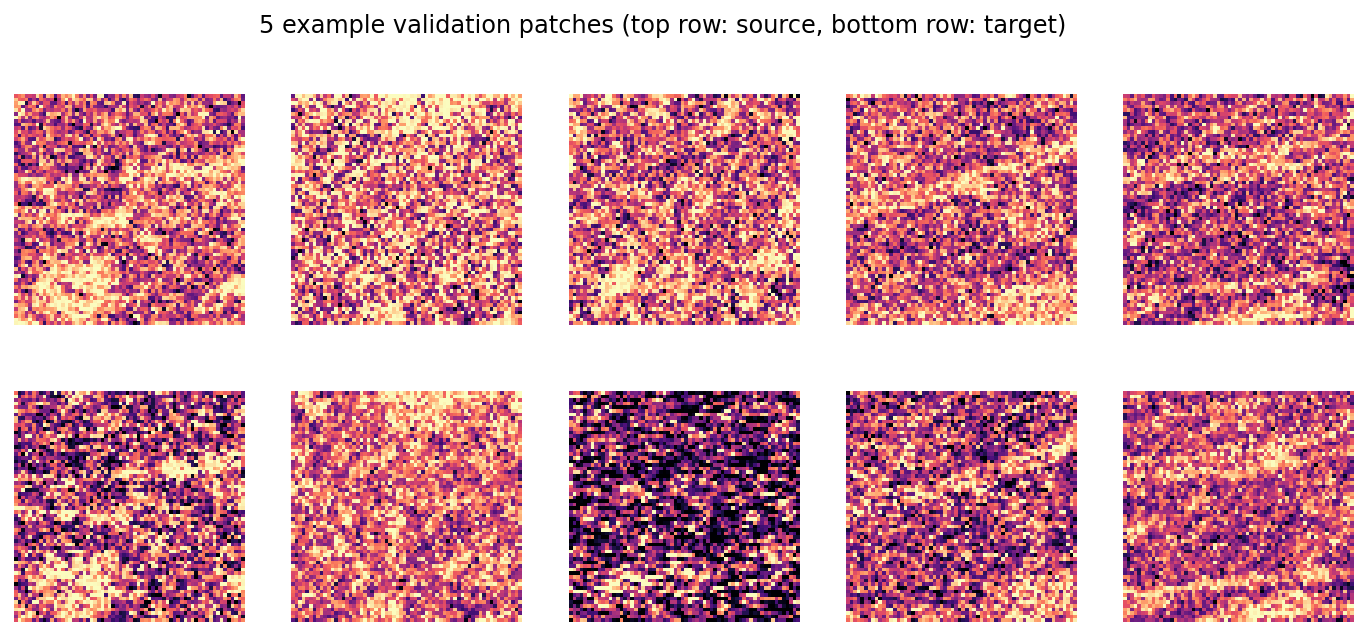

In [4]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

<hr style="height:2px;">

# CARE model

Before we construct the actual CARE model, we have to define its configuration via a `Config` object, which includes 
* parameters of the underlying neural network,
* the learning rate,
* the number of parameter updates per epoch,
* the loss function, and
* whether the model is probabilistic or not.

The defaults should be sensible in many cases, so a change should only be necessary if the training process fails.  

---

<span style="color:red;font-weight:bold;">Important</span>: Note that for this notebook we use a very small number of update steps per epoch for immediate feedback, whereas this number should be increased considerably (e.g. `train_steps_per_epoch=400`) to obtain a well-trained model.

In [5]:
config = Config(axes='YXC', 
                n_channel_in=1, 
                n_channel_out=1, 
                train_steps_per_epoch=25,
                train_epochs=100,
                unet_n_depth=2,
                unet_kern_size=3,
                train_batch_size=16,
                train_loss='mae')
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=25, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 100,
 'train_steps_per_epoch': 25,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

We now create a CARE model with the chosen configuration:

In [6]:
model = CARE(config, 'my_SEM_model', basedir='models')

/home/heinrichl/envs/care/lib/python3.7/site-packages/csbdeep/models/base_model.py:148: UserWarning: output path for model already exists, files may be overwritten: /home/heinrichl/code/CSBDeep/examples/denoising3D/models/my_SEM_model
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))
2021-09-27 00:35:54.865578: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-27 00:35:54.866634: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-27 00:35:54.889609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-27 00:35:54.890163: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla 

<hr style="height:2px;">

# Training

Training the model will likely take some time. We recommend to monitor the progress with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) (example below), which allows you to inspect the losses during training.
Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.

You can start TensorBoard from the current working directory with `tensorboard --logdir=.`
Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.

![](http://csbdeep.bioimagecomputing.com/img/tensorboard_denoising3D.png)

In [7]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-09-27 00:36:14.266203: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-27 00:36:14.284164: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

2021-09-27 00:36:14.956298: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-09-27 00:36:16.243347: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


25/25 [==============================] - 4s 48ms/step - loss: 0.2394 - mse: 0.0915 - mae: 0.2394 - val_loss: 0.2131 - val_mse: 0.0719 - val_mae: 0.2131
Epoch 2/100
25/25 [==============================] - 1s 22ms/step - loss: 0.2083 - mse: 0.0685 - mae: 0.2083 - val_loss: 0.1931 - val_mse: 0.0598 - val_mae: 0.1931
Epoch 3/100
25/25 [==============================] - 1s 22ms/step - loss: 0.1953 - mse: 0.0600 - mae: 0.1953 - val_loss: 0.1910 - val_mse: 0.0590 - val_mae: 0.1910
Epoch 4/100
25/25 [==============================] - 1s 22ms/step - loss: 0.1969 - mse: 0.0622 - mae: 0.1969 - val_loss: 0.1957 - val_mse: 0.0606 - val_mae: 0.1957
Epoch 5/100
25/25 [==============================] - 1s 22ms/step - loss: 0.1896 - mse: 0.0579 - mae: 0.1896 - val_loss: 0.1886 - val_mse: 0.0578 - val_mae: 0.1886
Epoch 6/100
25/25 [==============================] - 1s 22ms/step - loss: 0.1887 - mse: 0.0580 - mae: 0.1887 - val_loss: 0.1984 - val_mse: 0.0628 - val_mae: 0.1984
Epoch 7/100
25/25 [=========

25/25 [==============================] - 1s 22ms/step - loss: 0.1873 - mse: 0.0583 - mae: 0.1873 - val_loss: 0.1851 - val_mse: 0.0567 - val_mae: 0.1851
Epoch 50/100
25/25 [==============================] - 1s 22ms/step - loss: 0.1902 - mse: 0.0595 - mae: 0.1902 - val_loss: 0.1849 - val_mse: 0.0567 - val_mae: 0.1849
Epoch 51/100
25/25 [==============================] - 1s 22ms/step - loss: 0.1876 - mse: 0.0583 - mae: 0.1876 - val_loss: 0.1849 - val_mse: 0.0565 - val_mae: 0.1849

Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.
Epoch 52/100
25/25 [==============================] - 1s 22ms/step - loss: 0.1940 - mse: 0.0610 - mae: 0.1940 - val_loss: 0.1852 - val_mse: 0.0565 - val_mae: 0.1852
Epoch 53/100
25/25 [==============================] - 1s 22ms/step - loss: 0.1866 - mse: 0.0573 - mae: 0.1866 - val_loss: 0.1848 - val_mse: 0.0571 - val_mae: 0.1848
Epoch 54/100
25/25 [==============================] - 1s 22ms/step - loss: 0.1851 - mse: 0.0566 - mae: 0.1

Epoch 98/100
25/25 [==============================] - 1s 22ms/step - loss: 0.1833 - mse: 0.0560 - mae: 0.1833 - val_loss: 0.1850 - val_mse: 0.0566 - val_mae: 0.1850
Epoch 99/100
25/25 [==============================] - 1s 22ms/step - loss: 0.1801 - mse: 0.0543 - mae: 0.1801 - val_loss: 0.1845 - val_mse: 0.0567 - val_mae: 0.1845
Epoch 100/100
25/25 [==============================] - 1s 22ms/step - loss: 0.1917 - mse: 0.0603 - mae: 0.1917 - val_loss: 0.1845 - val_mse: 0.0567 - val_mae: 0.1845

Loading network weights from 'weights_best.h5'.


Plot final training history (available in TensorBoard during training):

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


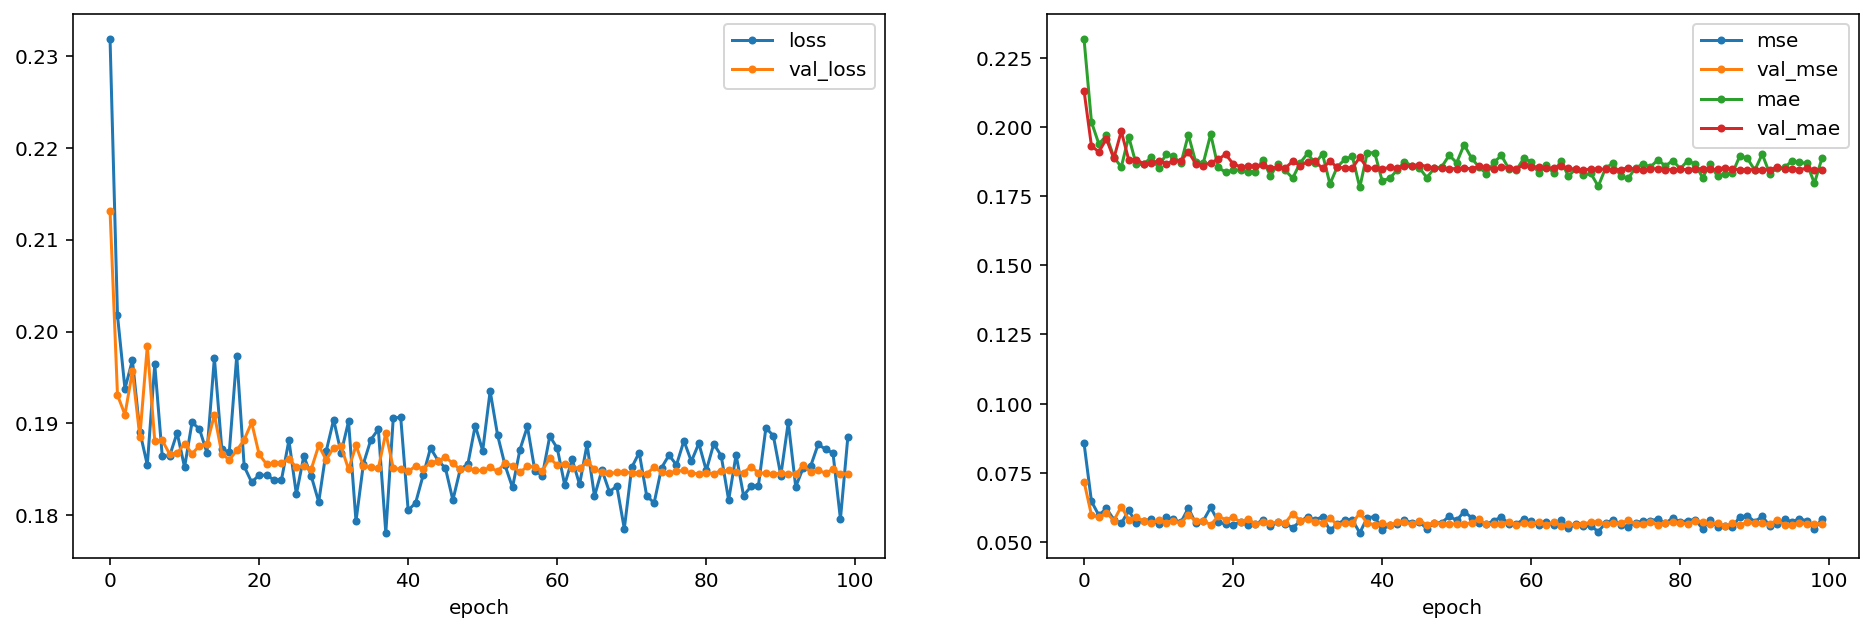

In [9]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

<hr style="height:2px;">

# Evaluation

Example results for validation images.

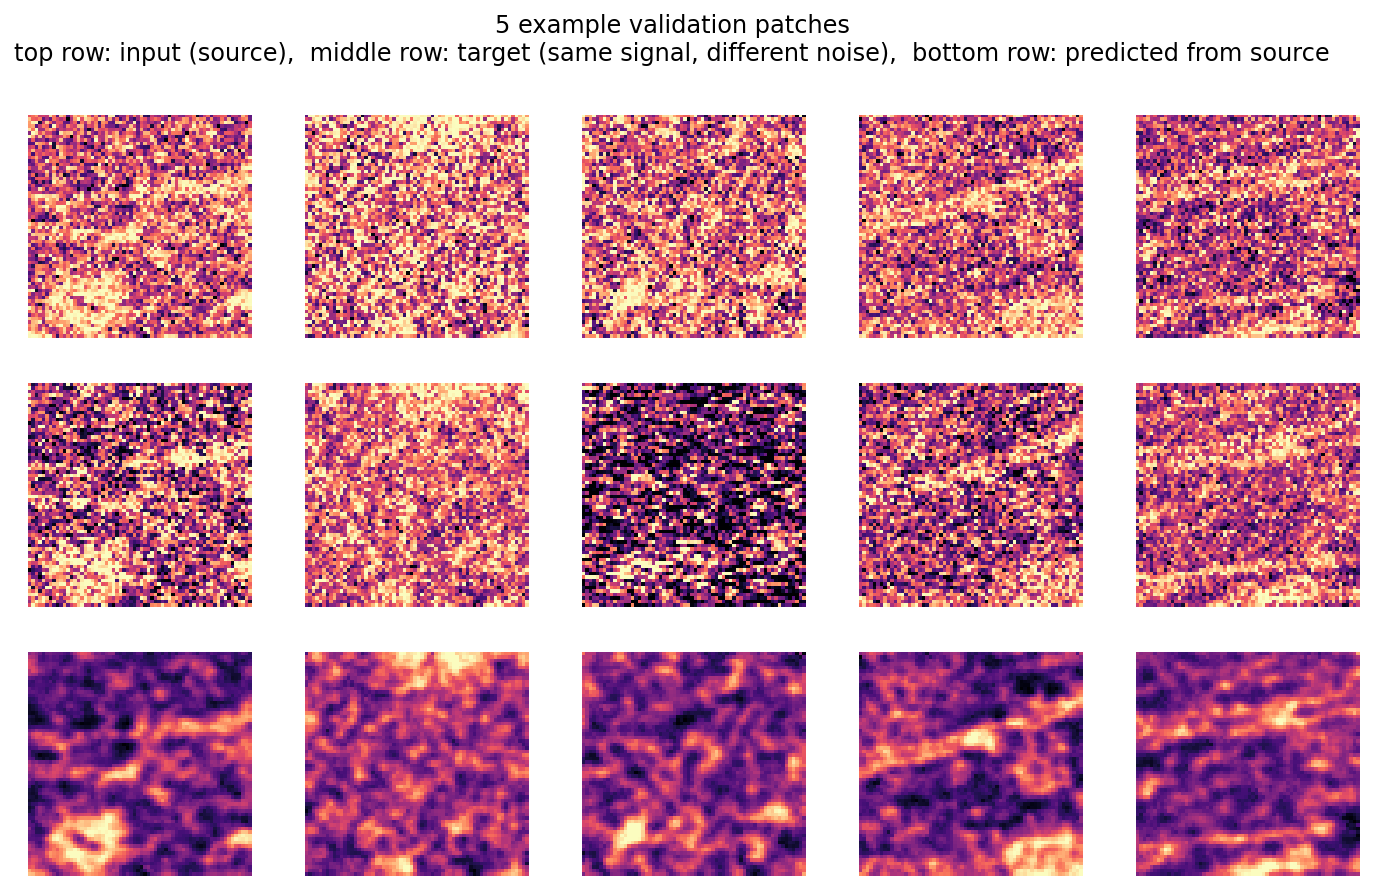

In [10]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (same signal, different noise),  '
             'bottom row: predicted from source');

<hr style="height:2px;">

# Export model to be used with CSBDeep **Fiji** plugins and **KNIME** workflows

See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

In [11]:
model.export_TF()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.


2021-09-27 00:37:53.625414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-27 00:37:53.625821: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-09-27 00:37:53.625878: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-09-27 00:37:53.625909: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-09-27 00:37:53.625920: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2021-09-27 00:37:53.625932: I tensorflow/stream_executor/platform/defa

INFO:tensorflow:SavedModel written to: /tmp/tmp041h6wk5/model/saved_model.pb

Model exported in TensorFlow's SavedModel format:
/home/heinrichl/code/CSBDeep/examples/denoising3D/models/my_SEM_model/TF_SavedModel.zip
